In [1]:
using DrWatson
@quickactivate

In [2]:
using main
using BlockDiagonals, LinearAlgebra, Plots, ProgressMeter
using Distributions, MCMCChains, Random

ProgressMeter.ijulia_behavior(:clear)
gr(fmt=:png)

Plots.GRBackend()

In [3]:
μ = [[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40], [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50], [4.93, 1.5], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]]

Σ = [diagm(fill(0.02, 2)) for _ in eachindex(μ)]

ξ = MixtureModel(
    [MvNormal(x .- 5.0, y) for (x, y) in zip(μ, Σ)],
    fill(1 / length(μ), length(μ))
)
model = Model(ξ=ξ);

In [4]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)

gr(legendfontsize=6, levels=4, msw=0.005, lw=0.001, legend=:bottomright, axis=false, ma=0.5, msc=:firebrick1)

function plt(;lim=(-5.5, 5.5), l=200, bar=false)
    sq = range(lim..., length=l)
    contourf(sq, sq, (x, y) -> model.U([x; y]) ^ -(1+1e-1), c=cls, lw=0.1, colorbar=bar, ratio=1, grid=false)
end

plt (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:34
  HMC:  0.8696130386961304


Acceptance Ratio = 0.8673
 94.720372 seconds (226.58 M allocations: 15.954 GiB, 6.94% gc time, 39.62% compilation time: 0% of which was recompilation)


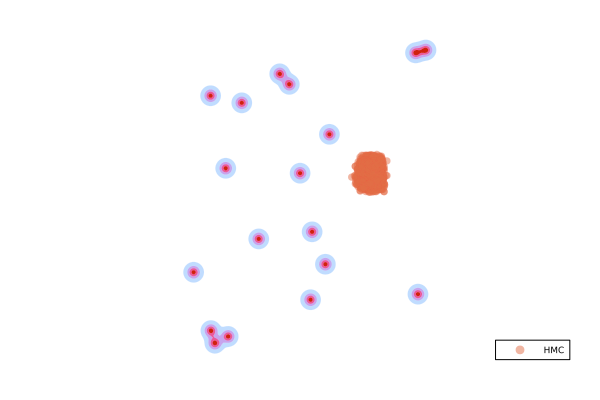

In [5]:
@time s1, a1 = mcmc(
    DualAverage(λ=20, δ=0.65),
    HMC(),
    model; n=1e4, n_burn=1e3
)
x_hmc = s1[a1, :]
scatter(plt(), x_hmc |> m2t, label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:03:53
  HaRAM:  0.28987101289871015


Acceptance Ratio = 0.2916
233.471847 seconds (779.60 M allocations: 58.038 GiB, 9.62% gc time, 0.71% compilation time)


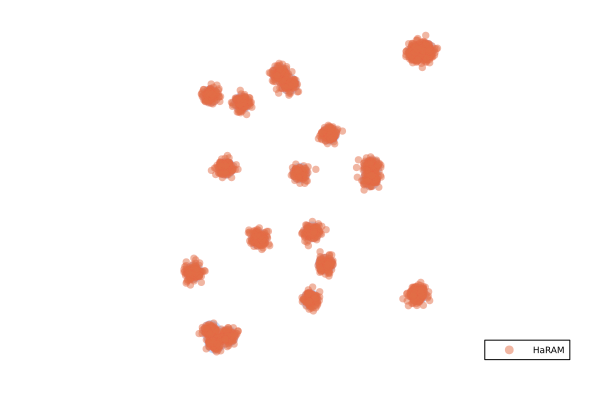

In [6]:
@time s2, a2 = mcmc(
    DualAverage(λ=20, δ=0.65),
    HaRAM(),
    model; n=1e4, n_burn=1e3
)
x_haram = s2[a2, :]
scatter(plt(), x_haram |> m2t, label="HaRAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  RAM:  0.13107899281883464


Acceptance Ratio = 0.1309
  2.994093 seconds (10.24 M allocations: 592.004 MiB, 10.40% gc time, 36.74% compilation time: 1% of which was recompilation)


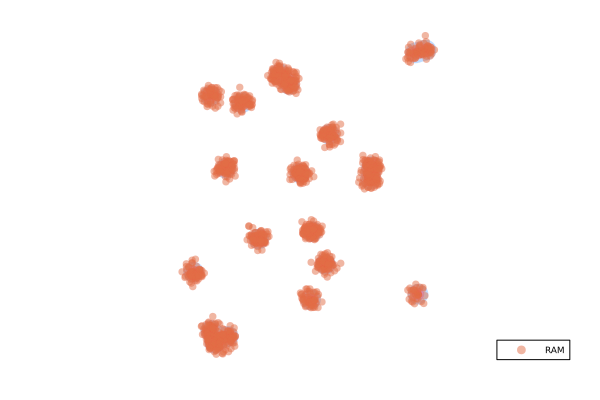

In [7]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(2, 2.0), z=randn(model.d)),
    model; n=1e4, n_burn=1e3
)
x_ram = s3[a3, :]
scatter(plt(), x_ram |> m2t, label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:07:52
  PEHMC:  0.5903723887375113


Acceptance Ratio = 0.5888
472.573546 seconds (1.11 G allocations: 47.228 GiB, 4.16% gc time, 10.35% compilation time)


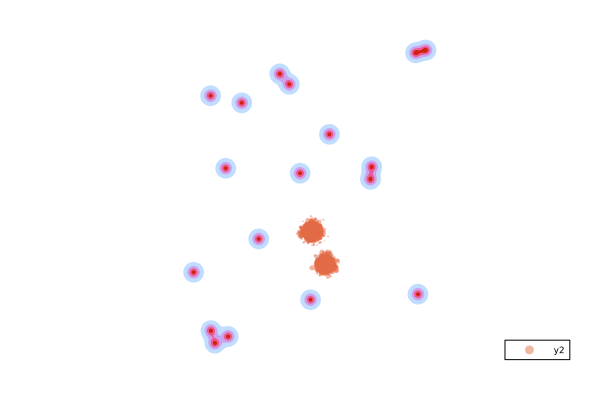

In [8]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.2, L=10, N=2),
    model; n=1e3, n_burn=1e2
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
scatter(plt(), x_pehmc |> m2t, ms=w_pehmc * 5, label="PEHMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
  HMC:  0.9004635942187074


Acceptance Ratio = 0.909
 35.483502 seconds (109.16 M allocations: 7.914 GiB, 9.24% gc time, 3.12% compilation time)


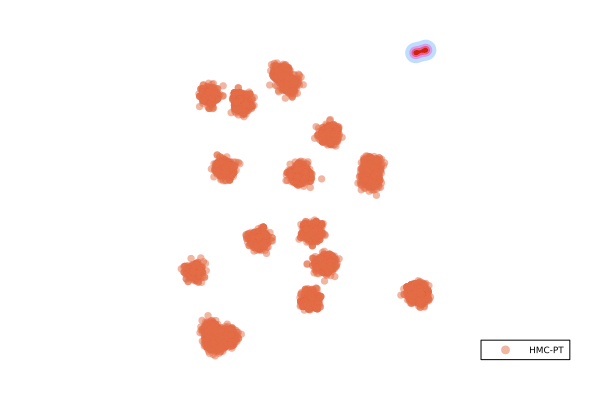

In [9]:
@time s5, a5 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HMC(ϵ=0.2, L=20),
    model; n=1e4, n_burn=1e3
)
x_pt_hmc = s5[a5, :]
scatter(plt(), x_pt_hmc |> m2t, label="HMC-PT")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
  HaRAM:  0.9023725115898554


Acceptance Ratio = 0.9011
 67.034230 seconds (208.16 M allocations: 15.332 GiB, 9.60% gc time, 0.48% compilation time)


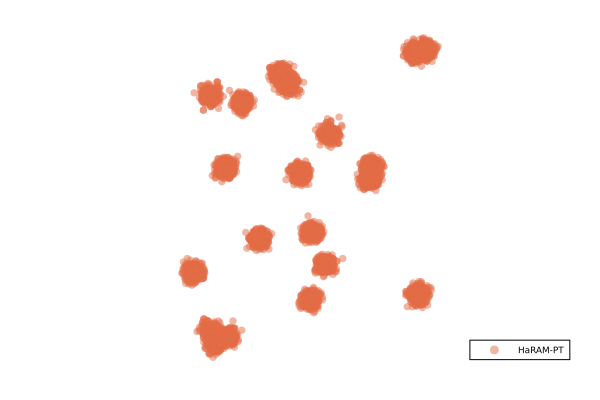

In [10]:
@time s6, a6 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HaRAM(ϵ=0.1, L=20, γ=0.8),
    model; n=1e4, n_burn=1e3
)
x_pt_haram = s6[a6, :]
scatter(plt(), x_pt_haram |> m2t, label="HaRAM-PT")